In [42]:
from jax import random, grad, vmap, jit, hessian, lax
import numpy as onp
import scipy.io
from scipy.interpolate import griddata
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax import config
from jax.flatten_util import ravel_pytree
from jax.nn import relu, elu
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

In [43]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [44]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [45]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)  # or Relu 
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)     # or Relu

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define operator loss
    def loss_operator(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred.flatten())**2)
        return loss
    
    def loss_pou(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        t, x = y[:,0], y[:,1]
        branch_params, trunk_params = params
        y = np.stack([t, x], axis=-1)  
        T = self.trunk_apply(trunk_params, y)
        phi_sum = np.sqrt(np.sum(T**2, axis=-1))
        loss = np.mean((phi_sum - 1)**2)
        return loss
    
    def loss(self, params, operator_batch ):
        loss_operator = self.loss_operator(params, operator_batch)
        loss = loss_operator
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, test_dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)
         # Progress bar
        test_data_iterator = iter(test_dataset)

        pbar = trange(nIter)
        self.test_loss_log = []
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)
           
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss(params, batch)

                test_operator_batch = next(test_data_iterator)

                test_loss = self.loss(params, test_operator_batch)

                # Store loss
                self.loss_log.append(loss_value)
                self.test_loss_log.append(test_loss)
  
                # Print loss
                pbar.set_postfix({'Loss': loss_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

In [46]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, P, length_scale):
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))
    # u = index_update(u, index[:,0], u0(x))
    u = u.at[:,0].set(u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        # u = index_update(u, index[1:-1, i + 1], np.linalg.solve(A, b1 + b2))
        u = u.at[1:-1, i + 1].set(np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (P, 2), 0, max(Nx, Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    u = np.tile(u, (P, 1))

    return u, y, s

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2, 1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

def generate_one_pou_training_data(key, m=101, P=100):
    # 随机采样时间和空间点
    t_pou = random.uniform(key, (P, 1))
    x_pou = random.uniform(key, (P, 1))
    
    y = np.hstack([t_pou, x_pou])  # shape = (P, 2)
    u = np.zeros((P, m))           
    s = np.zeros((P, 1))          
    return u, y, s

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train= vmap(generate_one_training_data, (0, None))(keys, P)

    u_train = np.float32(u_train.reshape(N * P, -1))
    y_train = np.float32(y_train.reshape(N * P, -1))
    s_train = np.float32(s_train.reshape(N * P, -1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P)

    u_test = np.float32(u_test.reshape(N * P**2, -1))
    y_test = np.float32(y_test.reshape(N * P**2, -1))
    s_test = np.float32(s_test.reshape(N * P**2, -1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

# Compute relative l2 error over N test samples.
def compute_error(key, P):
    # Generate one test sample
    u_test, y_test, s_test = generate_test_data(key, 1, P)
    # Predict  
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    # Compute relative l2 error
    error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
    return error_s

In [47]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 500 # number of input samples
N_test = 50
m = Nx   # number of input sensors
P_train = 100 # number of output sensors

u_train, y_train, s_train = generate_training_data(key, N, P_train)
u_test, y_test, s_test = generate_training_data(key, N_test, P_train)

In [48]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = DeepONet(branch_layers, trunk_layers)

In [49]:
# Create data set
batch_size = 1000
dataset = DataGenerator(u_train, y_train, s_train, batch_size)
dataset_test = DataGenerator(u_test, y_test, s_test, batch_size)

In [50]:
# Train
nIter = 10000
# model.train(dataset,dataset_test, nIter)


In [51]:
# Test data
N_test = 50 # number of input samples 
P_test = m  # number of sensors 
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)
# 
#保存参数
lam = f"{N}_{N_test}_{nIter}_l2"
# flat_params, _ = ravel_pytree(params)
# np.save('modified_MLP_lam_params_{}.npy'.format(lam), flat_params)
# print('modified_MLP_lam_params_{}.npy'.format(lam))
params = model.unravel_params(np.load('./parameters/modified_MLP_lam_params_{}.npy'.format(lam)))

# Compute error
error_s = vmap(compute_error, (0, None))(keys_test,P_test) 

print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 6.65e-02
std of relative L2 error of s: 2.43e-02


In [52]:
# np.save("./data/l2_loss_log", np.array(model.loss_log))
# np.save("./data/l2_test_loss_log", np.array(model.test_loss_log))
l2_loss_log = np.load("./data/l2_loss_log.npy")
l2_test_loss_log = np.load("./data/l2_test_loss_log.npy")

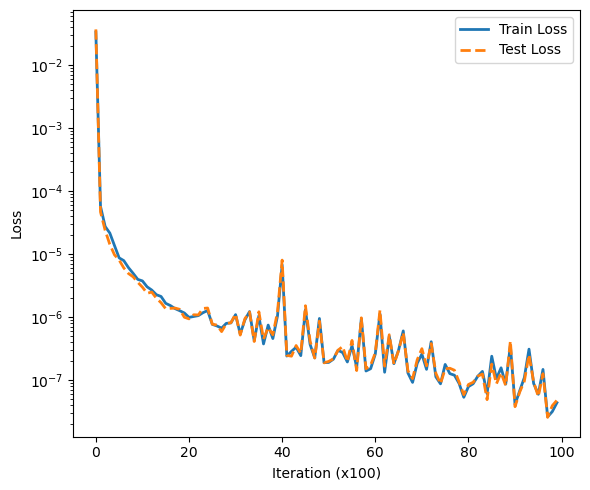

In [53]:
#Plot for loss function
plt.figure(figsize=(6,5))
# plt.plot(model.loss_log, "-", lw=2, label='Train Loss')
# plt.plot(model.test_loss_log, "--", lw=2, label='Test Loss')
plt.plot(l2_loss_log, "-", lw=2, label='Train Loss')
plt.plot(l2_test_loss_log, "--", lw=2, label='Test Loss')
plt.xlabel('Iteration (x100)')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.savefig('l2_loss_curve.png', dpi=300)
plt.show()

In [54]:
# Generate one test sample
key = random.PRNGKey(12345)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
print('Relative l2 errpr: {:.3e}'.format(error))

Relative l2 errpr: 1.297e+00


In [55]:

def load_one_test_sample(filename, index):
    import os
    if not os.path.exists(filename):
        raise FileNotFoundError(f"文件 {filename} 未找到。请先生成并保存数据。")
        
    print(f"<- 正在从 {filename} 加载第 {index} 个测试样本...")
    loaded = onp.load(filename)
    
    # 提取所有数据
    u_all = loaded['u_test_all']
    y_all = loaded['y_test_all']
    s_all = loaded['s_test_all']

    if index >= u_all.shape[0]:
        raise IndexError(f"索引 {index} 超出范围。文件只包含 {u_all.shape[0]} 个样本。")
    
    # 提取指定的单个样本
    u_test_np = u_all[index]
    y_test_np = y_all[index]
    s_test_np = s_all[index]

    # 转换为 JAX 数组并返回
    u_test = np.asarray(u_test_np)
    y_test = np.asarray(y_test_np)
    s_test = np.asarray(s_test_np)
    
    print("<- 样本加载成功！")
    return u_test, y_test, s_test

<- 正在从 ./data/adr_multiple_test_data.npz 加载第 2 个测试样本...
<- 样本加载成功！


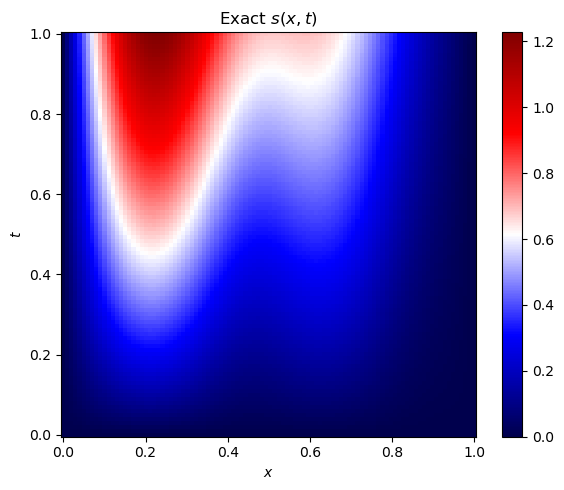

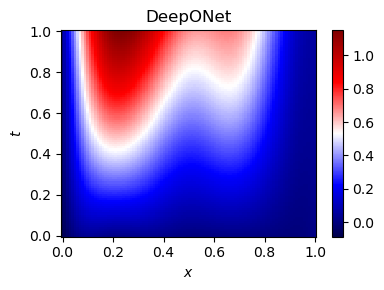

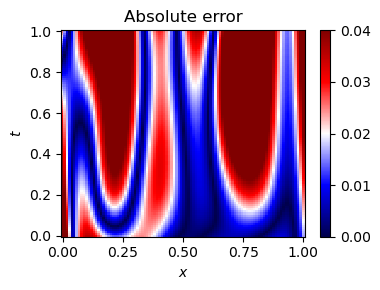

测试样本索引: 2, 相对 l2 误差: 1.546e-01


In [56]:
# --------------- 多次运行：加载和测试单个样本 ---------------

import os
# 导入必要的库和参数 (m, Nt 应该在你的代码中定义)
# from scipy.interpolate import griddata 
# import matplotlib.pyplot as plt

# 1. 定义参数
test_data_filename = './data/adr_multiple_test_data.npz'
sample_index_to_plot = 2  # 选择要加载的样本
Nx = m 

# 2. 加载指定的测试样本
u_test, y_test, s_test = load_one_test_sample(test_data_filename, sample_index_to_plot)

# 3. 预测
# params = model.get_params(model.opt_state)
params = model.unravel_params(np.load('./parameters/modified_MLP_lam_params_{}.npy'.format(lam)))
s_pred = model.predict_s(params, u_test, y_test)

# 4. 网格化数据
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

S_pred = griddata(onp.array(y_test), onp.array(s_pred.flatten()), (onp.array(XX), onp.array(TT)), method='cubic')
S_test = griddata(onp.array(y_test), onp.array(s_test.flatten()), (onp.array(XX), onp.array(TT)), method='cubic')


# Plot
fig = plt.figure(figsize=(6,5))
# plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()
# plt.savefig("exact_DR")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('DeepONet')
plt.tight_layout()
# plt.savefig("L2_predicted_DR")
plt.show()
plt.close()

fig = plt.figure(figsize=(4,3))
plt.pcolor(XX,TT, np.abs(S_pred - S_test), cmap='seismic', vmin=0, vmax = 0.04)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
# plt.savefig("L2_error_DR")
plt.show()

# 5. 计算相对 l2 误差 
# error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
error = np.mean((s_test - s_pred) ** 2)
print(f'测试样本索引: {sample_index_to_plot}, 相对 l2 误差: {error:.3e}')

# np.save("./parameters/DeepONet_pre_DR",S_pred)
# np.save("./parameters/DeepONet_error_DR",np.abs(S_pred - S_test))

In [57]:
# 计算 t=1 时，x在[0,1]上每隔0.2的预测误差
x_points = np.arange(0, 1.01, 0.2)
t_point = 1

# 找到对应的索引
t_idx = np.argmin(np.abs(t - t_point))  # 找到最接近 t=1 的索引
x_indices = [np.argmin(np.abs(x - xp)) for xp in x_points]  # 找到最接近每个 x_point 的索引
a = 0
print("t=1时各x位置的预测误差：")
for xi, xp in zip(x_indices, x_points):
    exact = S_test[xi, t_idx]
    pred = S_pred[xi, t_idx]
    abs_err = np.abs(pred - exact)
    print(f"x={xp:.1f}: 预测值={pred:.4f}, 精确值={exact:.4f}, 绝对误差={abs_err:.4e}")
    a = a+abs_err
print(a/5)


t=1时各x位置的预测误差：
x=0.0: 预测值=0.0163, 精确值=0.0000, 绝对误差=1.6265e-02
x=0.2: 预测值=0.0261, 精确值=0.0000, 绝对误差=2.6120e-02
x=0.4: 预测值=0.0359, 精确值=0.0000, 绝对误差=3.5902e-02
x=0.6: 预测值=0.0449, 精确值=0.0000, 绝对误差=4.4883e-02
x=0.8: 预测值=0.0535, 精确值=0.0000, 绝对误差=5.3494e-02
x=1.0: 预测值=0.0608, 精确值=0.0000, 绝对误差=6.0839e-02
0.0475009


In [58]:
# l2_loss_log = np.load("./parameters/l2_loss_log.npy")
# l2_test_loss_log = np.load("./parameters/l2_test_loss_log.npy")
# l2_pou_loss_log = np.load("./parameters/l2_pou_loss_log.npy")
# l2_pou_test_loss_log = np.load("./parameters/l2_pou_loss_log.npy")
# PI_loss_log = np.load("./parameters/PI_loss_log.npy")
# PI_test_loss_log = np.load("./parameters/PI_test_loss_log.npy")
# PI_POU_loss_log = np.load("./parameters/PI_POU_loss_log.npy")
# PI_POU_test_loss_log = np.load("./parameters/PI_POU_test_loss_log.npy")

In [59]:
# plt.figure(figsize=(6,5))
# # plt.plot(model.loss_log, "r-", lw=2, label='Train Loss')
# # plt.plot(model.test_loss_log, "r--", lw=2, label='Test Loss')
# plt.plot(l2_loss_log, "r--", lw=1, label='l2_loss Train Loss')
# plt.plot(l2_test_loss_log, "r-", lw=1, label='l2_loss Test Loss')
# plt.plot(l2_pou_loss_log, "b--", lw=1, label='l2_pou_loss Train Loss')
# plt.plot(l2_pou_test_loss_log, "b-", lw=1, label='l2_pou_loss Test Loss')
# plt.plot(PI_loss_log, "g--", lw=1, label='PI_loss Train Loss')
# plt.plot(PI_test_loss_log, "g-", lw=1, label='PI_loss Test Loss')
# plt.plot(PI_POU_loss_log, "y--", lw=1, label='PI_POU_loss Train Loss')
# plt.plot(PI_POU_test_loss_log, "y-", lw=1, label='PI_POU_loss Test Loss')
# plt.xlabel('Iteration (x100)')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.legend(loc='upper right', fontsize=7)
# plt.tight_layout()
# plt.savefig('loss_curve_all.png', dpi=300)
# plt.show()b

<- 正在从 ./data/adr_multiple_test_data.npz 加载第 2 个测试样本...
<- 样本加载成功！


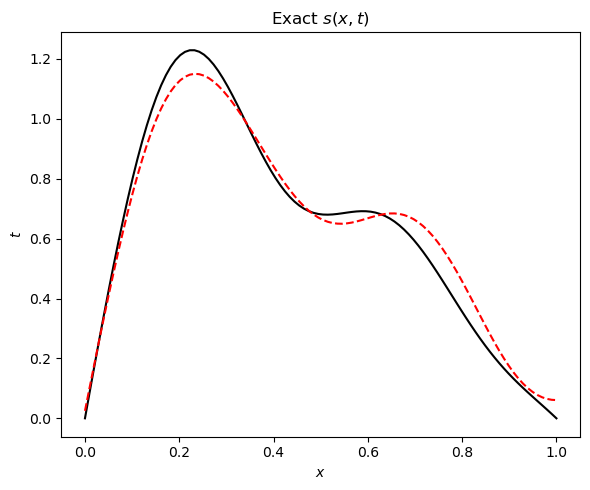

In [60]:
# --------------- 多次运行：加载和测试单个样本 ---------------

import os


# 1. 定义参数
test_data_filename = './data/adr_multiple_test_data.npz'
sample_index_to_plot = 2  # 选择要加载的第 16 个样本 (索引从 0 开始)
Nx = m # 假设 Nx 等于 m (Branch Net 输入维度)

# 2. 加载指定的测试样本
u_test, y_test, s_test = load_one_test_sample(test_data_filename, sample_index_to_plot)

# 3. 预测
# params = model.get_params(model.opt_state)
params = model.unravel_params(np.load('./parameters/modified_MLP_lam_params_{}.npy'.format(lam)))
s_pred = model.predict_s(params, u_test, y_test)

# 4. 网格化数据
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

S_pred = griddata(onp.array(y_test), onp.array(s_pred.flatten()), (onp.array(XX), onp.array(TT)), method='cubic')
S_test = griddata(onp.array(y_test), onp.array(s_test.flatten()), (onp.array(XX), onp.array(TT)), method='cubic')

S_exact_t1 = S_test[-1,:]
S_pred_t1 = S_pred[-1,:]
# np.save("./parameters/exact_DR",np.array(S_exact_t1))
# np.save("./parameters/DeepONet_predicted_DR",np.array(S_pred_t1))
# Plot

# Plot
fig = plt.figure(figsize=(6,5))
# plt.subplot(1,3,1)
plt.plot(x, S_exact_t1, "k-")
plt.plot(x,S_pred_t1,"r--")
# plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()
# plt.savefig("exact_DR")
plt.show()

    

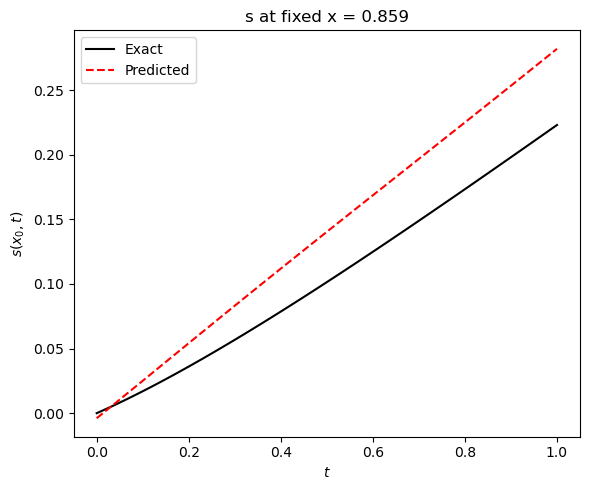

In [61]:
# 选择固定的 x 位置
x_index = 85
x0 = x[x_index]

S_exact_x0 = S_test[:, x_index]   # shape (Nt,)
S_pred_x0  = S_pred[:, x_index]   # shape (Nt,)

# np.save("./parameters/exact_DR_x_85",np.array(S_exact_x0))
# np.save("./parameters/DeepONet_predicted_DR_x_85",np.array(S_pred_x0))

fig = plt.figure(figsize=(6,5))
plt.plot(t, S_exact_x0, "k-", label="Exact")
plt.plot(t, S_pred_x0, "r--", label="Predicted")
plt.xlabel('$t$')
plt.ylabel('$s(x_0,t)$')
plt.title(f's at fixed x = {x0:.3f}')
plt.legend()
plt.tight_layout()
plt.show()
